In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils import data

# To Read Data
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
# To Interpret results & obtain plots
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import os

In [2]:

class ChestXRayDataset(Dataset):
    def __init__(self, **kwargs):
        self.path = kwargs.get('path')
        self.transform = kwargs.get('transform')
        self.data = datasets.ImageFolder(self.path, transform=self.transform)
        self.path_label_list = self.data.imgs


    '''This function should return sample count in the dataset'''
    def __len__(self):
        return len(self.data)

    '''This function should return a single sample and its ground truth value from the dataset corresponding to index parameter '''
    def __getitem__(self, index):
        # Load image and label from the dataset based on the index
        image_path, label = self.path_label_list[index]
        
        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image: {image_path}, {e}")
            return None, None

        # Print image size before transformation
        # print("Image size before transformation:", image.size)

        # Optionally apply transformations
        if self.transform:
            image = self.transform(image)

        # Print image size after transformation
        # print("Image size after transformation:", image.shape)

        return image, label

In [5]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog


# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])

# Prepare the dataset
dataset = ChestXRayDataset(path='folder', transform=None)

# Extract HOG features from images
X = []
y = []

for img, label in dataset:
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    hog_features = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    X.append(hog_features)
    y.append(label)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create an instance of SVC (Support Vector Classifier) and fit the model on the training data
model = SVC(kernel='rbf', C=1.0, random_state=42,probability=True)
model.fit(X_train, y_train)



SVC(probability=True, random_state=42)

Accuracy: 0.345
Accuracy: 0.3450
Macro Precision: 0.3510
Macro Recall: 0.3521
Macro F1 Score: 0.3265


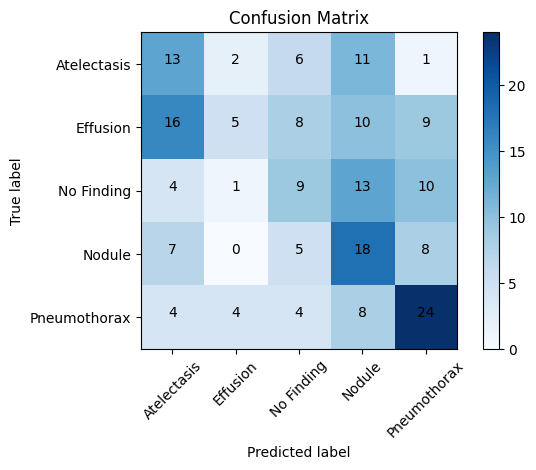

ValueError: too many values to unpack (expected 2)

In [7]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC

# Define the parameter grid (if you have specific parameters to tune, add them here)
param_grid = {
    
}
classifier = SVC(kernel='rbf',
               gamma=0.1,
               C=10.0)


# Setup the grid search with cross-validation
#grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the training data
#grid_search.fit(X_train, y_train)

# Get the best model from grid search
#best_model = grid_search.best_estimator_

##print("Best Model Parameters:", grid_search.best_params_)
#print("Best CV Accuracy:", grid_search.best_score_)

# Make predictions on the test data using the best model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)


# Make predictions on the testing data
#y_pred = model.predict(X_test)
#y_prob = model.predict_proba_(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


def plot_confusion_matrix(conf_matrix):
    plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar()
    classes = ['Atelectasis', 'Effusion', 'No Finding', 'Nodule', 'Pneumothorax']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, format(conf_matrix[i, j], 'd'), horizontalalignment="center", color="black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

#Return metric results as a dictionary
metrics = {
    'accuracy': acc,
    'precision': pre,
    'recall': recall,
    'f1_score': f1
}


#Print metrics
print("Accuracy: {:.4f}\nMacro Precision: {:.4f}\nMacro Recall: {:.4f}\nMacro F1 Score: {:.4f}".format(
    metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score']))

#plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_matrix)




from sklearn.preprocessing import label_binarize

#Convert y_test to binary format
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

#Get the probabilities for each class
#y_prob = grid_search.best_estimator_.predictproba(X_test)
#y_prob = GridSearchCV.best_estimator_.predictproba(X_test)

#Compute ROC curve and ROC area for each class


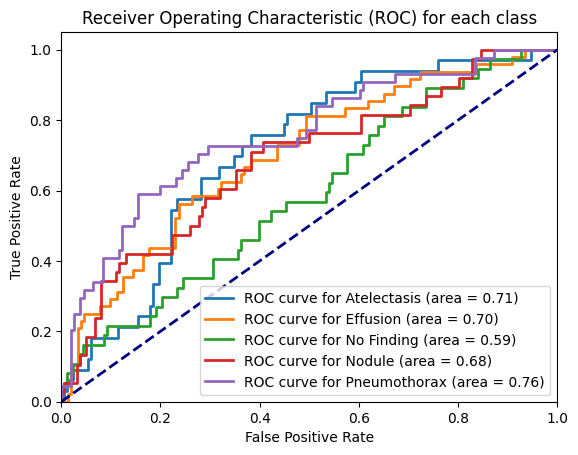

In [8]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i],_  = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#Plot ROC curves for each class
plt.figure()
lw = 2
classes = ['Atelectasis', 'Effusion', 'No Finding', 'Nodule', 'Pneumothorax']
for i in range(len(np.unique(y_test))):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve for {} (area = {:.2f})'.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for each class')
plt.legend(loc="lower right")
plt.show()